In [1]:
import pandas as pd
import numpy as np
import holidays
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from datetime import datetime, timedelta
from tqdm.auto import tqdm
from difflib import SequenceMatcher
from folium.plugins import HeatMap

In [2]:
#!pip install folium
#!pip install tqdm

In [3]:
# import bike_data from 2016Q4-2017Q4
bike_data_2016Q4 = pd.read_csv('2016_Bike_Share_Toronto_Ridership_Q4.csv',sep=",")
bike_data_2017Q1 = pd.read_csv('Bikeshare Ridership (2017 Q1).csv',sep=",")
bike_data_2017Q2 = pd.read_csv('Bikeshare Ridership (2017 Q2).csv',sep=",")
bike_data_2017Q3 = pd.read_csv('Bikeshare Ridership (2017 Q3).csv',sep=",")
bike_data_2017Q4 = pd.read_csv('Bikeshare Ridership (2017 Q4).csv',sep=",")
# later found out there were 4 rows missing from_station_name, therefore drop the rows
bike_data_2016Q4 = bike_data_2016Q4.dropna(how='any')

In [4]:
# convert trip_start_time to year-month-day
bike_data_2016Q4['trip_start_time'] = pd.to_datetime(bike_data_2016Q4['trip_start_time'],dayfirst=True)
bike_data_2017Q1['trip_start_time'] = pd.to_datetime(bike_data_2017Q1['trip_start_time'],dayfirst=True)
bike_data_2017Q2['trip_start_time'] = pd.to_datetime(bike_data_2017Q2['trip_start_time'],dayfirst=True)
bike_data_2017Q3['trip_start_time'] = pd.to_datetime(bike_data_2017Q3['trip_start_time'],format='%m/%d/%Y %H:%M')
bike_data_2017Q4['trip_start_time'] = pd.to_datetime(bike_data_2017Q4['trip_start_time'])

# use from_station_name and trip_start_time for further analysis 
bike_data_2016Q4 = bike_data_2016Q4.drop(['trip_stop_time','to_station_name'],axis=1)
bike_data_2017Q1 = bike_data_2017Q1.drop(['trip_stop_time','to_station_id','to_station_name'],axis=1)
bike_data_2017Q2 = bike_data_2017Q2.drop(['trip_stop_time','to_station_id','to_station_name'],axis=1)
bike_data_2017Q3 = bike_data_2017Q3.drop(['trip_stop_time','to_station_name'],axis=1)
bike_data_2017Q4 = bike_data_2017Q4.drop(['trip_stop_time','to_station_name'],axis=1)

# rename from_station_name to station_name
bike_data_2016Q4.rename(columns={'from_station_name':'station_name'}, inplace=True)
bike_data_2017Q1.rename(columns={'from_station_name':'station_name','from_station_id':'station_id'}, inplace=True)
bike_data_2017Q2.rename(columns={'from_station_name':'station_name','from_station_id':'station_id'}, inplace=True)
bike_data_2017Q3.rename(columns={'from_station_name':'station_name'}, inplace=True)
bike_data_2017Q4.rename(columns={'from_station_name':'station_name'}, inplace=True)

bike_data_2016Q4.head()

,trip_id,trip_start_time,trip_duration_seconds,station_name,user_type
0,462305,2016-10-01 00:00:00,394,Queens Quay W / Dan Leckie Way,Casual
1,462306,2016-10-01 00:00:00,533,Sherbourne St / Wellesley St,Member
2,462307,2016-10-01 00:00:00,383,Queens Quay W / Dan Leckie Way,Casual
3,462308,2016-10-01 00:01:00,1557,Cherry St / Distillery Ln,Casual
4,462309,2016-10-01 00:01:00,1547,Cherry St / Distillery Ln,Casual


In [5]:
# bike station information
import requests
import json

# get bike station information from website
station_data = requests.get('https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information')
bike_stations = json.loads(station_data.content)['data']['stations']
# create bike station information dataframe
bike_stations = pd.DataFrame(bike_stations)[['station_id', 'name', 'lat', 'lon']].astype({'station_id': 'int'})
# rename column name to station name
bike_stations.rename(columns={'name':'station_name'}, inplace=True)
# create a list of bike station names
bike_stations_list = list(bike_stations['station_name'])

In [6]:
# create list of station names for 2016 q4, 2017 q3 and 2017 q4
station_names_2016Q4 = list(set(bike_data_2016Q4['station_name']))
station_names_2017Q3 = list(set(bike_data_2017Q3['station_name']))
station_names_2017Q4 = list(set(bike_data_2017Q4['station_name']))

In [7]:
# use SequenceMatcher to match the inconsistent station names in 2016Q4 bike_data with station_data obtained from the website
ratio_list=[]
original_index=[]
station_index=[]
correct=0
incorrect=0
# go through all station names in 2016Q4 bike data
for i in range (len(station_names_2016Q4)):
    if station_names_2016Q4[i] not in bike_stations_list:
        for j in range (len(bike_stations_list)):
            # compare station names in bike_data with each station name in station_data obtained from the website
            s = SequenceMatcher(None, station_names_2016Q4[i], bike_stations_list[j])
            # if similarity ratio is bigger than 0.88, then break and record the station name with similarity ratio
            if s.ratio() >0.88:
                ratio_list.append(s.ratio())
                original_index.append(i)
                station_index.append(j)
                break;
        incorrect+=1
    else:
        correct+=1

In [8]:
# store the station names that will be updated 
old_station_names=[]
new_station_names=[]

for i in original_index:
    old_station_names.append(station_names_2016Q4[i])

for j in station_index:
    new_station_names.append(bike_stations_list[j])

In [9]:
# The first 10 station names that will be changed in bike data
old_station_names[0:10]

['Beverly St / College St W',
 '25 York St (ACC/Union Station South)',
 'College St W / Crawford St',
 'Queen St E / Berkely St',
 'Dundas St / Yonge St',
 'Front St / Yonge St (Hockey Hall of Fame)',
 'College St W / Major St',
 'St George St / Bloor St W',
 'College St W / Markham St',
 'Wellesley St E / Yonge St Green P']

In [10]:
# The first 10 station names that will be changed in station data
new_station_names[0:10]

['Beverley St / College St',
 '25 York St – Union Station South',
 'College St / Crawford St',
 'Queen St E / Berkeley St',
 'Dundas St W / Yonge St',
 'Front St W / Yonge St (Hockey Hall of Fame)',
 'College St / Major St',
 'St. George St / Bloor St W',
 'College St / Markham St',
 'Wellesley St E / Yonge St (Green P)']

In [11]:
# update station names 
for i in range(len(old_station_names)):
    bike_data_2016Q4['station_name'] = bike_data_2016Q4['station_name'].replace({old_station_names[i]:new_station_names[i]})

In [12]:
# merge 2016Q4 bike data with bike station names to add station_id, lat and lon column for further analysis
bike_data_2016Q4_final = (bike_data_2016Q4.merge(bike_stations, on='station_name'))
bike_data_2016Q4_final=bike_data_2016Q4_final.sort_values('trip_id')
bike_data_2016Q4_final.head()

,trip_id,trip_start_time,trip_duration_seconds,station_name,user_type,station_id,lat,lon
0,462305,2016-10-01 00:00:00,394,Queens Quay W / Dan Leckie Way,Casual,7075,43.636533,-79.395854
1024,462306,2016-10-01 00:00:00,533,Sherbourne St / Wellesley St E,Member,7042,43.667300,-79.374000
1,462307,2016-10-01 00:00:00,383,Queens Quay W / Dan Leckie Way,Casual,7075,43.636533,-79.395854
3544,462308,2016-10-01 00:01:00,1557,Cherry St / Distillery Ln,Casual,7107,43.650279,-79.356832
3545,462309,2016-10-01 00:01:00,1547,Cherry St / Distillery Ln,Casual,7107,43.650279,-79.356832


In [13]:
# use SequenceMatcher to match the inconsistent station names in 2017Q3 bike_data with station_data obtained from the website
ratio_list=[]
original_index=[]
station_index=[]
correct=0
incorrect=0
# go through all station names in 2017Q3 bike data
for i in range (len(station_names_2017Q3)):
    if station_names_2017Q3[i] not in bike_stations_list:
        for j in range (len(bike_stations_list)):
            # compare station names in bike_data with each station name in station_data obtained from the website
            s = SequenceMatcher(None, station_names_2017Q3[i], bike_stations_list[j])
            # if similarity ratio is bigger than 0.88, then break and record the station name with similarity ratio
            if s.ratio() >0.85:
                ratio_list.append(s.ratio())
                original_index.append(i)
                station_index.append(j)
                break;
        incorrect+=1
    else:
        correct+=1

In [14]:
# store the station names that will be updated 
old_station_names=[]
new_station_names=[]

for i in original_index:
    old_station_names.append(station_names_2017Q3[i])

for j in station_index:
    new_station_names.append(bike_stations_list[j])

In [15]:
# The first 10 station names that will be changed in bike data
old_station_names[0:10]

['25 York St (ACC/Union Station South)',
 'Queen St E / Berkely St',
 'Beverly St / College St',
 'Lake Shore Blvd W / Windermere Ave',
 'University Ave / King St W',
 'Summerhill Ave / MacLennan Ave - SMART',
 'Simcoe St / Wellington St W',
 'Dovercourt Rd / Harrison St - SMART',
 'Lower Spadina Ave / Lake Shore Blvd',
 'Queens Park / Bloor St W']

In [16]:
# The first 10 station names that will be changed in station data
new_station_names[0:10]

['25 York St – Union Station South',
 'Queen St E / Berkeley St',
 'Beverley St / College St',
 'Lakeshore Blvd W / Windermere Ave',
 'University Ave / Queen St W',
 'Summerhill Ave / Maclennan Ave',
 'Simcoe St / Wellington St South',
 'Dovercourt Rd / Harrison St (Green P) - SMART',
 'Lower Spadina Ave / Lakeshore Blvd',
 "Queen's Park / Bloor St W"]

In [17]:
# update station names 
for i in range(len(old_station_names)):
    bike_data_2017Q3['station_name'] = bike_data_2017Q3['station_name'].replace({old_station_names[i]:new_station_names[i]})

In [18]:
# merge 2017Q3 bike data with bike station names to add station_id, lat and lon column for further analysis
bike_data_2017Q3_final = (bike_data_2017Q3.merge(bike_stations, on='station_name'))
bike_data_2017Q3_final=bike_data_2017Q3_final.sort_values('trip_id')
bike_data_2017Q3_final.head()

,trip_id,trip_start_time,trip_duration_seconds,station_name,user_type,station_id,lat,lon
0,1253914,2017-07-01 00:00:00,910,Princess St / Adelaide St E,Member,7060,43.652123,-79.367139
7063,1253915,2017-07-01 00:01:00,837,Fort York Blvd / Capreol Ct,Casual,7000,43.639832,-79.395954
7064,1253916,2017-07-01 00:01:00,786,Fort York Blvd / Capreol Ct,Casual,7000,43.639832,-79.395954
12818,1253917,2017-07-01 00:01:00,1420,Elizabeth St / Edward St (Bus Terminal),Casual,7012,43.656026,-79.385327
12819,1253918,2017-07-01 00:01:00,1437,Elizabeth St / Edward St (Bus Terminal),Casual,7012,43.656026,-79.385327


In [19]:
# use SequenceMatcher to match the inconsistent station names in 2017Q3 bike_data with station_data obtained from the website
ratio_list=[]
original_index=[]
station_index=[]
correct=0
incorrect=0
# go through all station names in 2017Q4 bike data
for i in range (len(station_names_2017Q4)):
    if station_names_2017Q4[i] not in bike_stations_list:
        for j in range (len(bike_stations_list)):
            # compare station names in bike_data with each station name in station_data obtained from the website
            s = SequenceMatcher(None, station_names_2017Q4[i], bike_stations_list[j])
            # if similarity ratio is bigger than 0.88, then break and record the station name with similarity ratio
            if s.ratio() >0.85:
                ratio_list.append(s.ratio())
                original_index.append(i)
                station_index.append(j)
                break;
        incorrect+=1
    else:
        correct+=1

In [20]:
# store the station names that will be updated 
old_station_names=[]
new_station_names=[]

for i in original_index:
    old_station_names.append(station_names_2017Q4[i])

for j in station_index:
    new_station_names.append(bike_stations_list[j])

In [21]:
# The first 10 station names that will be changed in bike data
old_station_names[0:10]

['25 York St (ACC/Union Station South)',
 'Queen St E / Berkely St',
 'Beverly St / College St',
 'Lake Shore Blvd W / Windermere Ave',
 'University Ave / King St W',
 'Summerhill Ave / MacLennan Ave - SMART',
 'Simcoe St / Wellington St W',
 'Dovercourt Rd / Harrison St - SMART',
 'Lower Spadina Ave / Lake Shore Blvd',
 'Queens Park / Bloor St W']

In [22]:
# The first 10 station names that will be changed in station data
new_station_names[0:10]

['25 York St – Union Station South',
 'Queen St E / Berkeley St',
 'Beverley St / College St',
 'Lakeshore Blvd W / Windermere Ave',
 'University Ave / Queen St W',
 'Summerhill Ave / Maclennan Ave',
 'Simcoe St / Wellington St South',
 'Dovercourt Rd / Harrison St (Green P) - SMART',
 'Lower Spadina Ave / Lakeshore Blvd',
 "Queen's Park / Bloor St W"]

In [23]:
# update station names 
for i in range(len(old_station_names)):
    bike_data_2017Q4['station_name'] = bike_data_2017Q4['station_name'].replace({old_station_names[i]:new_station_names[i]})

In [24]:
# merge 2017Q4 bike data with bike station names to add station_id, lat and lon column for further analysis
bike_data_2017Q4_final = (bike_data_2017Q4.merge(bike_stations, on='station_name'))
bike_data_2017Q4_final=bike_data_2017Q4_final.sort_values('trip_id')
bike_data_2017Q4_final.head()

,trip_id,trip_start_time,trip_duration_seconds,station_name,user_type,station_id,lat,lon
0,1971685,2017-10-01 00:00:01,849,Queen St W / James St,Member,7275,43.652276,-79.380701
1578,1971686,2017-10-01 00:00:01,26,Stewart St / Bathurst St - SMART,Casual,7255,43.643307,-79.402176
2961,1971687,2017-10-01 00:00:22,1310,Hayter St / Laplante Ave,Member,7162,43.659167,-79.385556
4633,1971688,2017-10-01 00:00:38,631,Beverley St / College St,Member,7161,43.657500,-79.395278
7193,1971689,2017-10-01 00:00:55,1198,Thompson St / Broadview Ave - SMART,Member,7236,43.659471,-79.350325


In [25]:
# merge 2017Q1 bike data with bike station id to add lat and lon column for further analysis
bike_data_2017Q1_final = (bike_data_2017Q1.merge(bike_stations, on='station_id'))
bike_data_2017Q1_final = bike_data_2017Q1_final.drop(['station_name_y'],axis=1)
bike_data_2017Q1_final.rename(columns={'station_name_x':'station_name'}, inplace=True)
bike_data_2017Q1_final=bike_data_2017Q1_final.sort_values('trip_id')
bike_data_2017Q1_final.head()

,trip_id,trip_start_time,trip_duration_seconds,station_id,station_name,user_type,lat,lon
0,712382,2017-01-01 00:00:00,223,7051,Wellesley St E / Yonge St Green P,Member,43.665060,-79.383570
1160,712383,2017-01-01 00:00:00,279,7143,Kendal Ave / Bernard Ave,Member,43.671513,-79.408317
1759,712384,2017-01-01 00:05:00,1394,7113,Parliament St / Aberdeen Ave,Member,43.665278,-79.368333
2197,712385,2017-01-01 00:07:00,826,7077,College Park South,Member,43.659777,-79.382767
3699,712386,2017-01-01 00:08:00,279,7079,McGill St / Church St,Member,43.660694,-79.379052


In [26]:
# merge 2017Q2 bike data with bike station id to add lat and lon column for further analysis
bike_data_2017Q2_final = (bike_data_2017Q2.merge(bike_stations, on='station_id'))
bike_data_2017Q2_final = bike_data_2017Q2_final.drop(['station_name_y'],axis=1)
bike_data_2017Q2_final.rename(columns={'station_name_x':'station_name'}, inplace=True)
bike_data_2017Q2_final=bike_data_2017Q2_final.sort_values('trip_id')
bike_data_2017Q2_final.head()

,trip_id,trip_start_time,trip_duration_seconds,station_id,station_name,user_type,lat,lon
0,868665,2017-04-01 00:01:00,297,7073,Bremner Blvd / Spadina Ave,Member,43.640114,-79.393249
2518,868666,2017-04-01 00:07:00,236,7038,Dundas St / Yonge St,Member,43.656094,-79.381484
7218,868667,2017-04-01 00:08:00,380,7012,Elizabeth St / Edward St (Bus Terminal),Member,43.656026,-79.385327
9645,868668,2017-04-01 00:12:00,1299,7172,Strachan Ave / Princes' Blvd,Member,43.635000,-79.408889
10868,868669,2017-04-01 00:13:00,323,7039,Simcoe St / Dundas St W,Member,43.652327,-79.388254


In [27]:
# Concatenate bike data from 2016Q4 to 2017Q4
bike_data_2016Q4_2017Q4 = pd.concat([bike_data_2016Q4_final,bike_data_2017Q1_final,bike_data_2017Q2_final,bike_data_2017Q3_final,bike_data_2017Q4_final])
bike_data_2016Q4_2017Q4=bike_data_2016Q4_2017Q4.sort_values('trip_id')
bike_data_2016Q4_2017Q4=bike_data_2016Q4_2017Q4.reset_index()
bike_data_2016Q4_2017Q4=bike_data_2016Q4_2017Q4.drop(['index'],axis=1)
bike_data_2016Q4_2017Q4.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,lat,lon,station_id,station_name,trip_duration_seconds,trip_id,trip_start_time,user_type
0,43.636533,-79.395854,7075,Queens Quay W / Dan Leckie Way,394,462305,2016-10-01 00:00:00,Casual
1,43.667300,-79.374000,7042,Sherbourne St / Wellesley St E,533,462306,2016-10-01 00:00:00,Member
2,43.636533,-79.395854,7075,Queens Quay W / Dan Leckie Way,383,462307,2016-10-01 00:00:00,Casual
3,43.650279,-79.356832,7107,Cherry St / Distillery Ln,1557,462308,2016-10-01 00:01:00,Casual
4,43.650279,-79.356832,7107,Cherry St / Distillery Ln,1547,462309,2016-10-01 00:01:00,Casual


In [28]:
# round trip_start_time to hours
# add bolean variable for user type, 1 for member, 0 for non-member
member_user=[]
non_member_user=[]
hour_based_time=[]
for i in range (len(bike_data_2016Q4_2017Q4)):
    hour_based_time.append(bike_data_2016Q4_2017Q4['trip_start_time'][i].replace(microsecond=0,second=0,minute=0))
    if (bike_data_2016Q4_2017Q4['user_type'][i]=="Member"):
        member_user.append(1)
        non_member_user.append(0)
    else:
        member_user.append(0)
        non_member_user.append(1)

In [29]:
# add hour based time, boolean variable member_user and non_member user data to bike_data_2016Q4_2017Q4
bike_data_2016Q4_2017Q4['Hour_based_time'] = hour_based_time
bike_data_2016Q4_2017Q4['Member'] = member_user
bike_data_2016Q4_2017Q4['Non-Member'] = non_member_user

In [30]:
# extract season, year, month, day, and hour into lists
season_list=[]
year_list=[]
month_list=[]
day_list=[]
hour_list=[]
for i in range (len(bike_data_2016Q4_2017Q4)):
    year_list.append(bike_data_2016Q4_2017Q4['Hour_based_time'][i].year)
    month_list.append(bike_data_2016Q4_2017Q4['Hour_based_time'][i].month)
    day_list.append(bike_data_2016Q4_2017Q4['Hour_based_time'][i].day)
    hour_list.append(bike_data_2016Q4_2017Q4['Hour_based_time'][i].hour)
    # assign 1 to spring season, from March to May
    if (bike_data_2016Q4_2017Q4['Hour_based_time'][i].month >=3 and bike_data_2016Q4_2017Q4['Hour_based_time'][i].month <=5):
        season_list.append(1)
    # assign 2 to summer season, from June to August
    elif (bike_data_2016Q4_2017Q4['Hour_based_time'][i].month >=6 and bike_data_2016Q4_2017Q4['Hour_based_time'][i].month <=8):
        season_list.append(2)
    # assign 3 to fall season, from September to Novemeber
    elif (bike_data_2016Q4_2017Q4['Hour_based_time'][i].month >=9 and bike_data_2016Q4_2017Q4['Hour_based_time'][i].month <=11):
        season_list.append(3)
    # assign 4 to winter season, from December to February
    elif (bike_data_2016Q4_2017Q4['Hour_based_time'][i].month ==12 or bike_data_2016Q4_2017Q4['Hour_based_time'][i].month <=2):
        season_list.append(4)

In [31]:
# add day_of_week, season, year, month, day and hour columns to the original bike_data_2016Q4_2017Q4 dataset
bike_data_2016Q4_2017Q4['Day_of_Week'] = bike_data_2016Q4_2017Q4['Hour_based_time'].dt.dayofweek
bike_data_2016Q4_2017Q4['Season'] = season_list
bike_data_2016Q4_2017Q4['Year'] = year_list
bike_data_2016Q4_2017Q4['Month']= month_list
bike_data_2016Q4_2017Q4['Day'] = day_list
bike_data_2016Q4_2017Q4['Hour'] = hour_list
bike_data_2016Q4_2017Q4.head()

,lat,lon,station_id,station_name,trip_duration_seconds,trip_id,trip_start_time,user_type,Hour_based_time,Member,Non-Member,Day_of_Week,Season,Year,Month,Day,Hour
0,43.636533,-79.395854,7075,Queens Quay W / Dan Leckie Way,394,462305,2016-10-01 00:00:00,Casual,2016-10-01,0,1,5,3,2016,10,1,0
1,43.667300,-79.374000,7042,Sherbourne St / Wellesley St E,533,462306,2016-10-01 00:00:00,Member,2016-10-01,1,0,5,3,2016,10,1,0
2,43.636533,-79.395854,7075,Queens Quay W / Dan Leckie Way,383,462307,2016-10-01 00:00:00,Casual,2016-10-01,0,1,5,3,2016,10,1,0
3,43.650279,-79.356832,7107,Cherry St / Distillery Ln,1557,462308,2016-10-01 00:01:00,Casual,2016-10-01,0,1,5,3,2016,10,1,0
4,43.650279,-79.356832,7107,Cherry St / Distillery Ln,1547,462309,2016-10-01 00:01:00,Casual,2016-10-01,0,1,5,3,2016,10,1,0


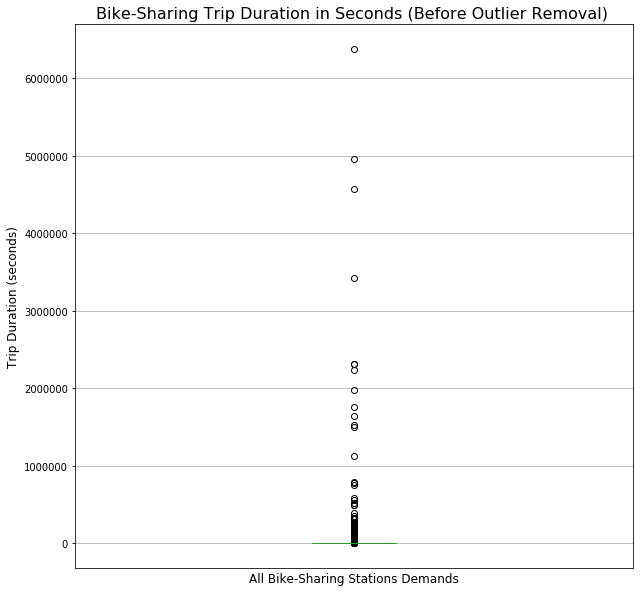

In [32]:
# box plot for trip_duration_seconds column
bike_data_2016Q4_2017Q4.boxplot(column='trip_duration_seconds',figsize=(10,10))
# plot title
plt.title('Bike-Sharing Trip Duration in Seconds (Before Outlier Removal) ',size = 16)
# clean x ticks
plt.xticks([])
# plot x label
plt.xlabel("All Bike-Sharing Stations Demands",size=12)
# plot y label
plt.ylabel("Trip Duration (seconds)",size=12)
# save graph to png
plt.savefig('boxplot1.png')

In [33]:
# take out outliers in the dataset by using Interquartile Range 
trip_duration =bike_data_2016Q4_2017Q4['trip_duration_seconds'].sort_values()
q1, q3= np.percentile(trip_duration,[25,75])
iqr = q3 - q1
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr) 

In [34]:
# get bike data between upper bound and lower bound and at least 60 seconds for further analysis
bike_data_2016Q4_2017Q4 = bike_data_2016Q4_2017Q4[(bike_data_2016Q4_2017Q4['trip_duration_seconds'] <=upper_bound) & (bike_data_2016Q4_2017Q4['trip_duration_seconds'] >=lower_bound) & 
                 (bike_data_2016Q4_2017Q4['trip_duration_seconds'] >=60)]

bike_data_2016Q4_2017Q4=bike_data_2016Q4_2017Q4.reset_index()
bike_data_2016Q4_2017Q4=bike_data_2016Q4_2017Q4.drop(['index'],axis=1)
bike_data_2016Q4_2017Q4.head()

,lat,lon,station_id,station_name,trip_duration_seconds,trip_id,trip_start_time,user_type,Hour_based_time,Member,Non-Member,Day_of_Week,Season,Year,Month,Day,Hour
0,43.636533,-79.395854,7075,Queens Quay W / Dan Leckie Way,394,462305,2016-10-01 00:00:00,Casual,2016-10-01,0,1,5,3,2016,10,1,0
1,43.667300,-79.374000,7042,Sherbourne St / Wellesley St E,533,462306,2016-10-01 00:00:00,Member,2016-10-01,1,0,5,3,2016,10,1,0
2,43.636533,-79.395854,7075,Queens Quay W / Dan Leckie Way,383,462307,2016-10-01 00:00:00,Casual,2016-10-01,0,1,5,3,2016,10,1,0
3,43.650279,-79.356832,7107,Cherry St / Distillery Ln,1557,462308,2016-10-01 00:01:00,Casual,2016-10-01,0,1,5,3,2016,10,1,0
4,43.650279,-79.356832,7107,Cherry St / Distillery Ln,1547,462309,2016-10-01 00:01:00,Casual,2016-10-01,0,1,5,3,2016,10,1,0


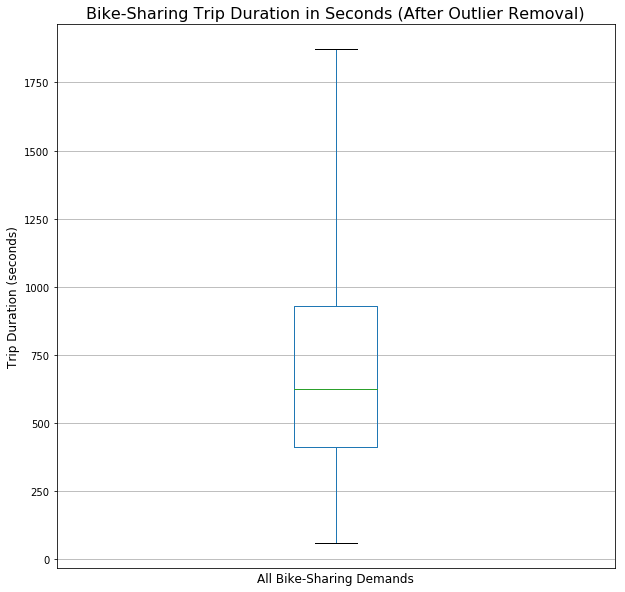

In [35]:
# plot box plot for trip_duration_seconds column (after outlier removal)
bike_data_2016Q4_2017Q4.boxplot(column='trip_duration_seconds',figsize=(10,10),whis=np.inf)
# plot title
plt.title('Bike-Sharing Trip Duration in Seconds (After Outlier Removal)', size = 16)
# clean x ticks
plt.xticks([])
# plot x label
plt.xlabel("All Bike-Sharing Demands",size=12)
# plot y label
plt.ylabel("Trip Duration (seconds)",size=12)
# save graph to png
plt.savefig('boxplot2.png')

In [36]:
# count bike sharing demand for each season
season_demand = bike_data_2016Q4_2017Q4['Season'].value_counts().sort_index()
season_demand = season_demand.reset_index()
season_demand=season_demand.rename(columns = {'index':'Season','Season':'Demand'})
# convert season labels to strings
season_label={1:'Spring',2:'Summer',3:'Fall',4:'Winter'}
season_demand['Season']=season_demand['Season'].map(season_label)

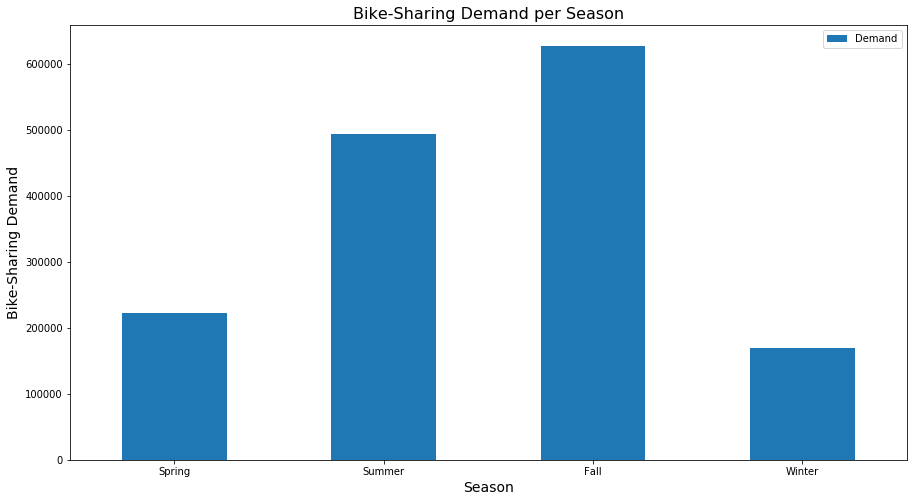

In [37]:
# plot bar graph for bike sharing demand for each season
season_demand.plot.bar(x='Season',y='Demand',figsize=(15,8))
plt.xticks(rotation=360)
plt.title('Bike-Sharing Demand per Season',size = 16)
# plot x label
plt.xlabel("Season",size=14)
# plot y label
plt.ylabel("Bike-Sharing Demand",size=14)
# save graph to png
plt.savefig('3.png')

In [38]:
# count bike sharing demand for each month
month_demand = bike_data_2016Q4_2017Q4['Month'].value_counts().sort_index()
month_demand = month_demand.reset_index()
month_demand=month_demand.rename(columns = {'index':'Month','Month':'Demand'})
# convert month labels to strings
month_label={1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sept',10:'Oct',11:'Nov',12:'Dec'}
month_demand['Month']=month_demand['Month'].map(month_label)

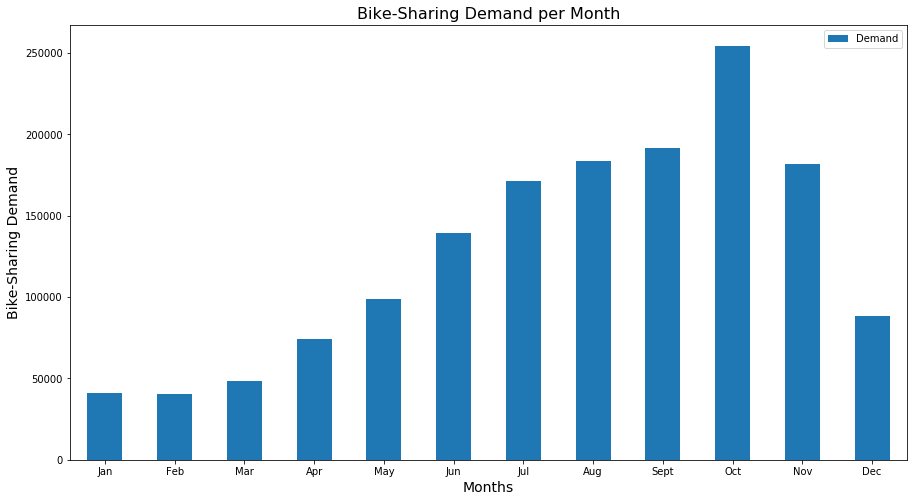

In [39]:
# plot bar graph for bike sharing demand for each month
month_demand.plot.bar(x='Month',y='Demand',figsize=(15,8))
plt.xticks(rotation=360)
plt.title('Bike-Sharing Demand per Month',size = 16)
# plot x label
plt.xlabel("Months",size=14)
# plot y label
plt.ylabel("Bike-Sharing Demand",size=14)
# save graph to png
plt.savefig('4.png')

In [40]:
# count bike sharing demand for each day of week
days_of_week_demand =bike_data_2016Q4_2017Q4['Day_of_Week'].value_counts().sort_index()
days_of_week_demand = days_of_week_demand.reset_index()
days_of_week_demand=days_of_week_demand.rename(columns = {'index':'Day_of_Week','Day_of_Week':'Demand'})
# convert day of week labels to strings
days_of_week_label={0:'Mon',1:'Tues',2:'Wed',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}
days_of_week_demand['Day_of_Week']=days_of_week_demand['Day_of_Week'].map(days_of_week_label)

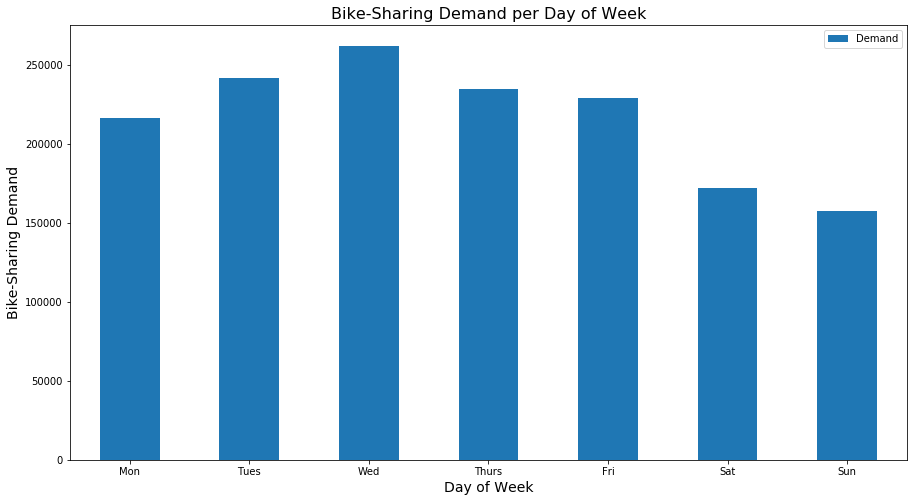

In [41]:
# plot bar graph for bike sharing demand for each day of week
days_of_week_demand.plot.bar(x='Day_of_Week',y='Demand',figsize=(15,8))
plt.xticks(rotation=360)
plt.title('Bike-Sharing Demand per Day of Week',size = 16)
# plot x label
plt.xlabel("Day of Week",size=14)
# plot y label
plt.ylabel("Bike-Sharing Demand",size=14)
# save graph to png
plt.savefig('5.png')

In [42]:
# count bike sharing demand for every hour
hour_demand =bike_data_2016Q4_2017Q4['Hour'].value_counts().sort_index()
hour_demand = hour_demand.reset_index()
hour_demand=hour_demand.rename(columns = {'index':'Hour','Hour':'Demand'})

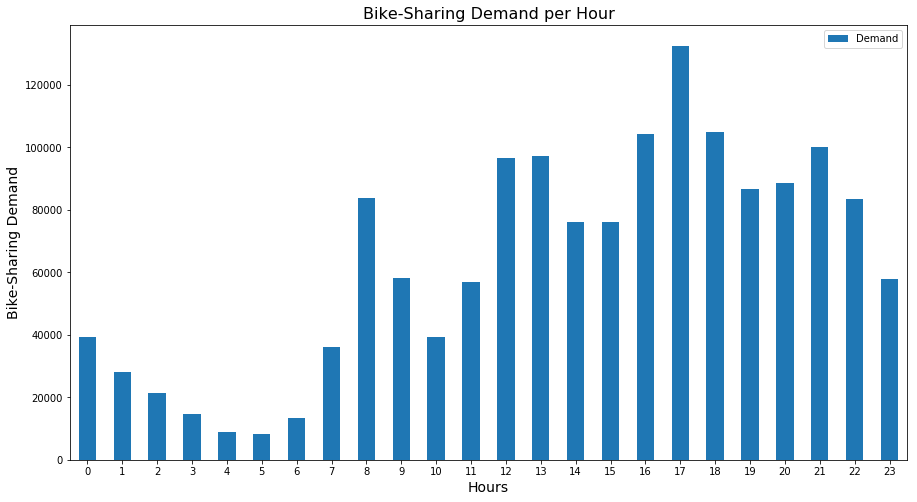

In [43]:
# plot bar graph for bike sharing demand for every hour
hour_demand.plot.bar(x='Hour',y='Demand',figsize=(15,8))
plt.xticks(rotation=360)
plt.title('Bike-Sharing Demand per Hour',size = 16)
# plot x label
plt.xlabel("Hours",size=14)
# plot y label
plt.ylabel("Bike-Sharing Demand",size=14)
# save graph to png
plt.savefig('6.png')

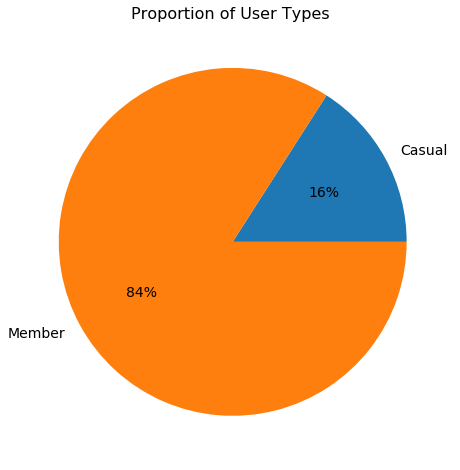

In [44]:
# count bike sharing demand based on user type
user_type =bike_data_2016Q4_2017Q4['user_type'].value_counts().sort_index()
# plot pie chart to show proportion of user types
plt.figure(figsize=(15,8))
plt.pie(
    # chart data
    user_type,
    # chart labels 
    labels=user_type.index,
    #display percentage
    autopct='%1.0f%%',
    shadow=False,
    # font size 
    textprops={'size': 14},
    )

# plot title
plt.title('Proportion of User Types ',size = 16)
# save graph to png
plt.savefig('7.png')

In [45]:
# import weather data for 2016Q4 to 2017Q4
weather_data_201610 = pd.read_csv('20161001-20161031.csv',encoding = "ISO-8859-1")
weather_data_201611 = pd.read_csv('20161101-20161130.csv',encoding = "ISO-8859-1")
weather_data_201612 = pd.read_csv('20161201-20161231.csv',encoding = "ISO-8859-1")
weather_data_201701 = pd.read_csv('20170101-20170131.csv',encoding = "ISO-8859-1")
weather_data_201702 = pd.read_csv('20170201-20170228.csv',encoding = "ISO-8859-1")
weather_data_201703 = pd.read_csv('20170301-20170331.csv',encoding = "ISO-8859-1")
weather_data_201704 = pd.read_csv('20170401-20170430.csv',encoding = "ISO-8859-1")
weather_data_201705 = pd.read_csv('20170501-20170531.csv',encoding = "ISO-8859-1")
weather_data_201706 = pd.read_csv('20170601-20170630.csv',encoding = "ISO-8859-1")
weather_data_201707 = pd.read_csv('20170701-20170731.csv',encoding = "ISO-8859-1")
weather_data_201708 = pd.read_csv('20170801-20170831.csv',encoding = "ISO-8859-1")
weather_data_201709 = pd.read_csv('20170901-20170930.csv',encoding = "ISO-8859-1")
weather_data_201710 = pd.read_csv('20171001-20171031.csv',encoding = "ISO-8859-1")
weather_data_201711 = pd.read_csv('20171101-20171130.csv',encoding = "ISO-8859-1")
weather_data_201712 = pd.read_csv('20171201-20171231.csv',encoding = "ISO-8859-1")

# concat weather data for 2016Q4 to 2017Q4
weather_data= pd.concat([weather_data_201610,weather_data_201611,weather_data_201612,
                         weather_data_201701,weather_data_201702,weather_data_201703,weather_data_201704,
                             weather_data_201705,weather_data_201706,weather_data_201707,weather_data_201708,
                             weather_data_201709,weather_data_201710,weather_data_201711,weather_data_201712])

In [46]:
# check number of missing values in weather data
weather_missing=weather_data.isna().sum().reset_index()
weather_missing=weather_missing.rename(columns = {'index':'Attribute',0:'# of Missing Values'})
weather_missing

,Attribute,# of Missing Values
0,Date/Time,0
1,Year,0
2,Month,0
3,Day,0
4,Time,0
5,Temp (¡ãC),12
6,Temp Flag,10966
7,Dew Point Temp (¡ãC),12
8,Dew Point Temp Flag,10966
9,Rel Hum (%),11


In [47]:
# drop uncessary variables
weather_data = weather_data.drop(['Year','Weather','Month','Day','Time','Temp Flag','Dew Point Temp Flag','Rel Hum Flag',
                                 'Wind Dir Flag','Wind Dir (10s deg)','Wind Spd Flag','Wind Chill','Visibility Flag','Stn Press Flag','Hmdx','Hmdx Flag','Wind Chill Flag'],axis=1)

In [48]:
# convert data/time to time stampe and rename columns 
weather_data['Date/Time'] = pd.to_datetime(weather_data['Date/Time'])
weather_data=weather_data.rename(columns = {'Date/Time':'Time','Temp (¡ãC)':'Temp (°C)','Dew Point Temp (¡ãC)':'Dew Point Temp (°C)'})
weather_data.Time = weather_data.Time.astype(str)
weather_data.head()

,Time,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Spd (km/h),Visibility (km),Stn Press (kPa)
0,2016-10-01 00:00:00,14.1,12.0,87.0,30.0,16.1,101.44
1,2016-10-01 01:00:00,14.3,11.5,83.0,28.0,16.1,101.43
2,2016-10-01 02:00:00,13.9,11.6,86.0,28.0,16.1,101.37
3,2016-10-01 03:00:00,13.9,11.8,87.0,35.0,16.1,101.28
4,2016-10-01 04:00:00,14.0,11.9,87.0,28.0,16.1,101.26


In [49]:
# combine bike data with weather data on time 
bike_data_2016Q4_2017Q4.Hour_based_time = bike_data_2016Q4_2017Q4.Hour_based_time.astype(str)
bike_weather_data=pd.merge(weather_data, bike_data_2016Q4_2017Q4, left_on="Time",right_on="Hour_based_time")
bike_weather_data = bike_weather_data.drop(['Hour_based_time','trip_start_time'],axis=1)
bike_weather_data.head()

,Time,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Spd (km/h),Visibility (km),Stn Press (kPa),lat,lon,station_id,...,trip_id,user_type,Member,Non-Member,Day_of_Week,Season,Year,Month,Day,Hour
0,2016-10-01 00:00:00,14.1,12.0,87.0,30.0,16.1,101.44,43.636533,-79.395854,7075,...,462305,Casual,0,1,5,3,2016,10,1,0
1,2016-10-01 00:00:00,14.1,12.0,87.0,30.0,16.1,101.44,43.667300,-79.374000,7042,...,462306,Member,1,0,5,3,2016,10,1,0
2,2016-10-01 00:00:00,14.1,12.0,87.0,30.0,16.1,101.44,43.636533,-79.395854,7075,...,462307,Casual,0,1,5,3,2016,10,1,0
3,2016-10-01 00:00:00,14.1,12.0,87.0,30.0,16.1,101.44,43.650279,-79.356832,7107,...,462308,Casual,0,1,5,3,2016,10,1,0
4,2016-10-01 00:00:00,14.1,12.0,87.0,30.0,16.1,101.44,43.650279,-79.356832,7107,...,462309,Casual,0,1,5,3,2016,10,1,0


In [50]:
# find out each bike stations hourly bike demand 
rush_hour=bike_weather_data[bike_weather_data['Hour']==17]
rush_hour_demand=rush_hour.groupby(['station_id','lat','lon']).agg({'Non-Member': 'sum','Member':'sum'})
rush_hour_demand = rush_hour_demand.reset_index()
rush_hour_demand['Total_Demand'] = rush_hour_demand['Member']+rush_hour_demand['Member']
rush_hour_demand['station_id'] = rush_hour_demand['station_id'].astype(int).astype(object)
rush_hour_demand['lat'] = rush_hour_demand['lat'].astype(float).astype(object)
rush_hour_demand['lon'] = rush_hour_demand['lon'].astype(float).astype(object)
rush_hour_demand['Non-Member'] = rush_hour_demand['Non-Member'].astype(int).astype(object)
rush_hour_demand['Member'] = rush_hour_demand['Member'].astype(int).astype(object)
rush_hour_demand['Total_Demand'] = rush_hour_demand['Total_Demand'].astype(int).astype(object)
rush_hour_demand['norm_demand']=(rush_hour_demand['Total_Demand']-rush_hour_demand['Total_Demand'].min())/(rush_hour_demand['Total_Demand'].max()-rush_hour_demand['Total_Demand'].min())
rush_hour_demand.head()

,station_id,lat,lon,Non-Member,Member,Total_Demand,norm_demand
0,7000,43.6398,-79.396,133,518,1036,0.206897
1,7001,43.648,-79.3709,253,416,832,0.165998
2,7002,43.6673,-79.3994,186,871,1742,0.348436
3,7003,43.6672,-79.4028,87,596,1192,0.238172
4,7004,43.6565,-79.3891,53,763,1526,0.305132


In [51]:
# create map center at the City of Toronto
toronto_cordinates = (43.6532, -79.3832)
# reference from https://www.freecodecamp.org/news/real-world-data-science-project-traffic-accident-analysis-e5a36775ee11/
def generateBaseMap(default_location=toronto_cordinates, default_zoom_start=10):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [52]:
# create heat map with normalized each bike station's demand
base_map = generateBaseMap()
HeatMap(data=list(zip(rush_hour_demand.lat.values, rush_hour_demand.lon.values, rush_hour_demand.norm_demand.values)),min_opacity=0.5,radius=13, max_zoom=13).add_to(base_map)

In [53]:
# create heatmap legend
import branca.colormap as cm
linear = cm.LinearColormap(
    ['blue','cyan','lime', 'yellow', 'red'],
    vmin=0, vmax=1
)
linear.caption = 'Normalized Bike-Sharing Demand for 17:00'
linear.add_to(base_map)

In [54]:
# display heat map for normalized bike sharing demand at 17:00
base_map

In [55]:
# create hours with empty demand for 2016Q4 to 2017Q4
temp_hour_list=[]
from datetime import timedelta, datetime

start_date = datetime(2016, 10, 1, 0, 0, 0)
for td in (start_date + timedelta(minutes=60*it) for it in range(24*(365+92))):
    temp_hour_list.append(td.strftime("%Y-%m-%d %H:%M:%S"))


In [56]:
# create a dataframe with empty demand hours
empty_time =pd.DataFrame(temp_hour_list)
empty_time.columns=['Time']

In [57]:
# count hourly bike-sharing demand by using groupby
demand_count = bike_weather_data.groupby(['Time']).agg({'Non-Member': 'sum','Member':'sum'})
demand_count = demand_count.reset_index()
demand_count['Total_Demand'] = demand_count.sum(axis=1)
demand_count.columns=['Time','Non-Member','Member','Total_Demand']
demand_count.head()

,Time,Non-Member,Member,Total_Demand
0,2016-10-01 00:00:00,31,131,162
1,2016-10-01 01:00:00,27,85,112
2,2016-10-01 02:00:00,13,75,88
3,2016-10-01 03:00:00,6,60,66
4,2016-10-01 04:00:00,5,37,42


In [58]:
# merge empty demand hours with actual demand hours
hour_bike_demand = pd.merge(empty_time, demand_count, on="Time",how='outer')
# fill 0 to all NA hours
hour_bike_demand= hour_bike_demand.fillna(0)
# convert non-member, member and total demand to integer type
hour_bike_demand['Non-Member'] = hour_bike_demand['Non-Member'].astype(int)
hour_bike_demand['Member'] = hour_bike_demand['Member'].astype(int)
hour_bike_demand['Total_Demand'] = hour_bike_demand['Total_Demand'].astype(int)

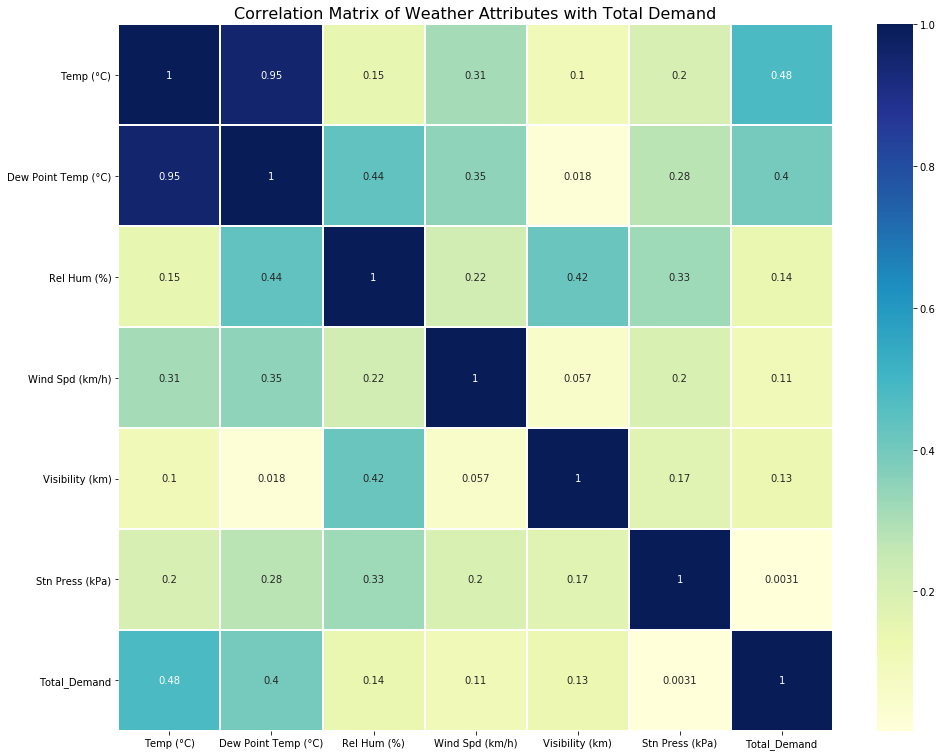

In [59]:
# merge hourly weather data with hourly bike demand data
demand_with_weather = pd.merge(weather_data, hour_bike_demand, on="Time")
# use total demand to create correlation matrix of weather attributes
weather_demand = demand_with_weather.drop(['Non-Member','Member'],axis=1)
plt.figure(figsize=(16,13))
# use absolute coorelation value
weather_corr = weather_demand.corr().abs()
# convert correlation matrix to a heat map
sns.heatmap(weather_corr, cmap="YlGnBu",xticklabels=weather_corr.columns,yticklabels=weather_corr.columns, annot=True,linewidths=1)
# plot title
plt.title('Correlation Matrix of Weather Attributes with Total Demand',size = 16)
plt.yticks(rotation=360)
# save graph to png
plt.savefig('corr.png')

In [60]:
hour_timestamp = pd.to_datetime(temp_hour_list)

In [61]:
# store season for all empty demand hours into lists
season_list=[]
for i in range (len(hour_timestamp)):
    if (hour_timestamp[i].month >=3 and hour_timestamp[i].month <=5):
        season_list.append(1)
    elif (hour_timestamp[i].month >=6 and hour_timestamp[i].month <=8):
        season_list.append(2)
    elif (hour_timestamp[i].month >=9 and hour_timestamp[i].month <=11):
        season_list.append(3)
    elif (hour_timestamp[i].month ==12 or hour_timestamp[i].month <=2):
        season_list.append(4)
    else:
        print(i)


In [62]:
# store year,month,day,and hour for empty demand hours into lists
year_list=[]
month_list=[]
day_list=[]
hour_list=[]
time_hour=[]
for i in range (len(hour_timestamp)):
    year_list.append(hour_timestamp[i].year)
    month_list.append(hour_timestamp[i].month)
    day_list.append(hour_timestamp[i].day)
    hour_list.append(hour_timestamp[i].hour)
    time_hour.append(hour_timestamp[i].replace(microsecond=0,second=0,minute=0))

In [63]:
# add time, day of week,season,year,month,day and hour to empty demand hours
empty_time['Time'] = pd.to_datetime(empty_time['Time'])
empty_time['Day_of_Week'] = empty_time['Time'].dt.dayofweek
empty_time['Season'] = season_list
empty_time['Year'] = year_list
empty_time['Month']= month_list
empty_time['Day'] = day_list
empty_time['Hour'] = hour_list
empty_time.head()
empty_time.Time = empty_time.Time.astype(str)


In [64]:
# find out if the day from 2016Q4 to 2017Q4 is a Canadian holiday or not
canada_holidays=holidays.Canada(years=[2016,2017]) 
holiday_list=[]
holiday_count=0
for i in range (len(hour_timestamp)):
    if (hour_timestamp[i] in canada_holidays) ==True:
        holiday_list.append(1)
        holiday_count+1
    else:
        holiday_list.append(0)

In [65]:
# get all bike station ids
station_list=list(set(bike_weather_data["station_id"]))
station_list.sort()

In [66]:
# separate each bike station information into lists
station_info=[]
for i in station_list:
    station_info.append(bike_weather_data[bike_weather_data["station_id"]==i])

In [67]:
# for each bike station, create a dataframe that contains time, temperature, real humidity, wind speed, station press, day of week, year , eason, month, day, hour and holiday 
all_station=[]
for i in tqdm(range (len(station_info))):
    # count bike sharing demand for different user types
    sum_df = station_info[i].groupby(['Time']).agg({'Non-Member': 'sum','Member':'sum'})
    sum_df = sum_df.reset_index()
    sum_df['Total Demand'] = sum_df.sum(axis=1)
    sum_df.columns=['Time','Non-Member','Member','Total_Demand']
    # convert timestamp to string for merging bike data with empty demand hours
    sum_df.Time = sum_df.Time.astype(str)
    final_station_info = pd.merge(empty_time, sum_df, on="Time",how='outer')
    final_station_info= final_station_info.fillna(0)
    # since there aren't enough bike share data, fill hours with zero total demand to 1, member demand to 1 
    final_station_info.loc[final_station_info.Total_Demand == 0 ,['Total_Demand','Member']]=1,1
    final_station_info['Non-Member'] = final_station_info['Non-Member'].astype(int)
    final_station_info['Member'] = final_station_info['Member'].astype(int)
    final_station_info['Total_Demand'] = final_station_info['Total_Demand'].astype(int)
    # combine weather data with each bike station's bike data
    final_with_weather = pd.merge(weather_data, final_station_info, on="Time")
    # add bolean holiday variable 
    final_with_weather['Holiday']=holiday_list
    # add station id column
    final_with_weather['Station ID'] = np.repeat(station_list[i],len(final_with_weather))
    final_with_weather = final_with_weather[['Time','Temp (°C)','Rel Hum (%)','Wind Spd (km/h)',
                 'Stn Press (kPa)','Day_of_Week','Year','Season','Month','Day','Hour','Holiday',
                 'Non-Member','Member','Total_Demand','Station ID']]
    # fill missing weather data with mean values
    final_with_weather= final_with_weather.fillna(final_with_weather.mean())
    # store each bike station data into a list
    all_station.append(final_with_weather)

In [68]:
# regression tree based prediction model, predict total bike sharing demand for each bike station
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
error_list_regressionTree=[]
# for each bike station creates a regression tree based prediction model 
for i in tqdm(range (len(all_station))):
    temp=all_station[i]
    # features, independet variables
    X=temp.drop(['Non-Member','Member','Total_Demand','Time','Station ID'],axis=1)
    # label, dependent variable
    y=temp['Total_Demand']
    # use cross validation by randomly spiliting 70% of data as training dataset, 30% as testing dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0)
    clf=DecisionTreeRegressor(random_state=0)
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    # calculate error by using root mean square error
    error_list_regressionTree.append(np.sqrt(mean_squared_error(y_test, y_pred)))
# find out average rmse for all bike stations
sum(error_list_regressionTree)/len(error_list_regressionTree)

0.8833925558485293

In [69]:
# regression tree based prediction model, predict member bike sharing demand for each bike station
error_list_regressionTree=[]
# for each bike station creates a regression tree based prediction model 
for i in tqdm(range (len(all_station))):
    temp=all_station[i]
    # features, independet variables
    X=temp.drop(['Non-Member','Member','Total_Demand','Time','Station ID'],axis=1)
    # label, depdent variable
    y=temp['Member'] 
    # use cross validation by randomly spiliting 70% of data as training dataset, 30% as testing dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0)
    clf=DecisionTreeRegressor(random_state=0)
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    # calculate error by using root mean square error
    error_list_regressionTree.append(np.sqrt(mean_squared_error(y_test, y_pred)))
# find out average rmse for all bike stations
sum(error_list_regressionTree)/len(error_list_regressionTree)

0.746319550370079

In [70]:
# regression tree based prediction model, predict non-member bike sharing demand for each bike station
error_list_regressionTree=[]
# for each bike station creates a regression tree based prediction model 
for i in tqdm(range (len(all_station))):
    temp=all_station[i]
    # features, independet variables
    X=temp.drop(['Non-Member','Member','Total_Demand','Time','Station ID'],axis=1)
    # label, depdent variable
    y=temp['Non-Member']
    # use cross validation by randomly spiliting 70% of data as training dataset, 30% as testing dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0)
    clf=DecisionTreeRegressor(random_state=0)
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    # calculate error by using root mean square error
    error_list_regressionTree.append(np.sqrt(mean_squared_error(y_test, y_pred)))
# find out average rmse for all bike stations
sum(error_list_regressionTree)/len(error_list_regressionTree)

0.5134196546198891

In [71]:
# gbm based prediction model, predict total bike sharing demand for each bike station
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
error_list_GBM=[]
# test 50, 100, and 500 number of estimators(trees)
param_grid = {"n_estimators": [50,100,500]}
# for each bike station creates a gbm based prediction model 
for i in tqdm(range (len(all_station))):
    temp=all_station[i]
    # features, independet variables
    X=temp.drop(['Non-Member','Member','Total_Demand','Time','Station ID'],axis=1)
    # label, depdent variable
    y=temp['Total_Demand']
    # use cross validation by randomly spiliting 70% of data as training dataset, 30% as testing dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0)
    clf= GradientBoostingRegressor(random_state=0)
    # use gridsearchcv package to find out the optimal number of estimators
    new_clf = GridSearchCV(clf, param_grid)
    new_clf.fit(X_train,y_train)
    best_num_of_trees = list(new_clf.best_params_.values())[0]
    # use the optimal number of estimators to create the prediction model
    best_clf=GradientBoostingRegressor(n_estimators=best_num_of_trees,random_state=0)
    best_clf.fit(X_train,y_train)
    y_pred=best_clf.predict(X_test)
    # calculate error by using root mean square error
    error_list_GBM.append(np.sqrt(mean_squared_error(y_test, y_pred)))
# find out average rmse for all bike stations
sum(error_list_GBM)/len(error_list_GBM)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default v

0.6778400088646986

In [72]:
# gbm based prediction model, predict member bike sharing demand for each bike station
error_list_GBM=[]
# test 50, 100, and 500 number of estimators(trees)
param_grid = {"n_estimators": [50,100,500]}
# for each bike station creates a gbm based prediction model 
for i in tqdm(range (len(all_station))):
    temp=all_station[i]
    # features, independet variables
    X=temp.drop(['Non-Member','Member','Total_Demand','Time','Station ID'],axis=1)
    # label, depdent variable 
    y=temp['Member']  
    # use cross validation by randomly spiliting 70% of data as training dataset, 30% as testing dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0)
    clf= GradientBoostingRegressor(random_state=0)
    # use gridsearchcv package to find out the optimal number of estimators
    new_clf = GridSearchCV(clf, param_grid)
    new_clf.fit(X_train,y_train)
    best_num_of_trees = list(new_clf.best_params_.values())[0]
    # use the optimal number of estimators to create the prediction model
    best_clf=GradientBoostingRegressor(n_estimators=best_num_of_trees,random_state=0)
    best_clf.fit(X_train,y_train)
    y_pred=best_clf.predict(X_test)
    # calculate error by using root mean square error
    error_list_GBM.append(np.sqrt(mean_squared_error(y_test, y_pred)))
# find out average rmse for all bike stations
sum(error_list_GBM)/len(error_list_GBM)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default v

0.5846126843071422

In [73]:
# gbm based prediction model, predict non-member bike sharing demand for each bike station
error_list_GBM=[]
# test 50, 100, and 500 number of estimators(trees)
param_grid = {"n_estimators": [50,100,500]}
# for each bike station creates a gbm based prediction model 
for i in tqdm(range (len(all_station))):
    temp=all_station[i]
    # features, independet variables
    X=temp.drop(['Non-Member','Member','Total_Demand','Time','Station ID'],axis=1)
    # label, depdent variable    
    y=temp['Non-Member'] 
    # use cross validation by randomly spiliting 70% of data as training dataset, 30% as testing dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0)
    clf= GradientBoostingRegressor(random_state=0)
    # use gridsearchcv package to find out the optimal number of estimators
    new_clf = GridSearchCV(clf, param_grid)
    new_clf.fit(X_train,y_train)
    best_num_of_trees = list(new_clf.best_params_.values())[0]
    # use the optimal number of estimators to create the prediction model
    best_clf=GradientBoostingRegressor(n_estimators=best_num_of_trees,random_state=0)
    best_clf.fit(X_train,y_train)
    y_pred=best_clf.predict(X_test)
    # calculate error by using root mean square error
    error_list_GBM.append(np.sqrt(mean_squared_error(y_test, y_pred)))
# find out average rmse for all bike stations
sum(error_list_GBM)/len(error_list_GBM)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default v

0.3561737205164227

In [74]:
# random forest based prediction model, predict total bike sharing demand for each bike station
from sklearn.ensemble import RandomForestRegressor
error_list_randomForest=[]
# test 50, 100, and 500 number of estimators(trees)
param_grid = {"n_estimators": [50,100,500]}
# for each bike station creates a random forest based prediction model 
for i in tqdm(range (len(all_station))):
    temp=all_station[i]
    # features, independet variables
    X=temp.drop(['Non-Member','Member','Total_Demand','Time','Station ID'],axis=1)
    # label, depdent variable    
    y=temp['Total_Demand'] 
    # use cross validation by randomly spiliting 70% of data as training dataset, 30% as testing dataset   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0)
    clf= RandomForestRegressor(random_state=0)
    # use gridsearchcv package to find out the optimal number of estimators
    new_clf = GridSearchCV(clf, param_grid)
    new_clf.fit(X_train,y_train)
    best_num_of_trees = list(new_clf.best_params_.values())[0]
    # use the optimal number of estimators to create the prediction model
    best_clf=RandomForestRegressor(n_estimators=best_num_of_trees,random_state=0)
    best_clf.fit(X_train,y_train)
    y_pred=best_clf.predict(X_test)
    # calculate error by using root mean square error
    error_list_randomForest.append(np.sqrt(mean_squared_error(y_test, y_pred)))
# find out average rmse for all bike stations
sum(error_list_randomForest)/len(error_list_randomForest)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default v

0.6390624256372244

In [75]:
# random forest based prediction model, predict member bike sharing demand for each bike station
from sklearn.ensemble import RandomForestRegressor
error_list_randomForest=[]
# test 50, 100, and 500 number of estimators(trees)
param_grid = {"n_estimators": [50,100,500]}
# for each bike station creates a random forest based prediction model 
for i in tqdm(range (len(all_station))):
    temp=all_station[i]
    # features, independet variables
    X=temp.drop(['Non-Member','Member','Total_Demand','Time','Station ID'],axis=1)
    # label, depdent variable    
    y=temp['Member']  
    # use cross validation by randomly spiliting 70% of data as training dataset, 30% as testing dataset   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0)
    clf= RandomForestRegressor(random_state=0)
    # use gridsearchcv package to find out the optimal number of estimators
    new_clf = GridSearchCV(clf, param_grid)
    new_clf.fit(X_train,y_train)
    best_num_of_trees = list(new_clf.best_params_.values())[0]
    # use the optimal number of estimators to create the prediction model
    best_clf=RandomForestRegressor(n_estimators=best_num_of_trees,random_state=0)
    best_clf.fit(X_train,y_train)
    y_pred=best_clf.predict(X_test)
    # calculate error by using root mean square error
    error_list_randomForest.append(np.sqrt(mean_squared_error(y_test, y_pred)))
# find out average rmse for all bike stations
sum(error_list_randomForest)/len(error_list_randomForest)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default v

0.5386299116062703

In [82]:
# random forest based prediction model, predict non member bike sharing demand for each bike station
from sklearn.ensemble import RandomForestRegressor
error_list_randomForest=[]
param_grid = {"n_estimators": [50,100,500]}
# test 50, 100, and 500 number of estimators(trees)
for i in tqdm(range (len(all_station))):
    temp=all_station[i]
    # features, independet variables
    X=temp.drop(['Non-Member','Member','Total_Demand','Time','Station ID'],axis=1)
    # label, depdent variable    
    y=temp['Non-Member']
    # use cross validation by randomly spiliting 70% of data as training dataset, 30% as testing dataset   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0)
    clf= RandomForestRegressor(random_state=0)
    # use gridsearchcv package to find out the optimal number of estimators
    new_clf = GridSearchCV(clf, param_grid)
    new_clf.fit(X_train,y_train)
    best_num_of_trees = list(new_clf.best_params_.values())[0]
    # use the optimal number of estimators to create the prediction model
    best_clf=RandomForestRegressor(n_estimators=best_num_of_trees,random_state=0)
    best_clf.fit(X_train,y_train)
    y_pred=best_clf.predict(X_test)
    # calculate error by using root mean square error
    error_list_randomForest.append(np.sqrt(mean_squared_error(y_test, y_pred)))
# find out average rmse for all bike stations
sum(error_list_randomForest)/len(error_list_randomForest)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default v

0.3667917030222177

In [89]:
# find out bike-sharing demand from 2016Q4 to 2017 Q4 for each station
total_demand=bike_data_2016Q4_2017Q4.groupby(['station_id','lat','lon']).agg({'Non-Member': 'sum','Member':'sum'})
total_demand = total_demand.reset_index()
total_demand['Total_Demand'] = total_demand['Non-Member']+total_demand['Member']
total_demand['station_id'] = total_demand['station_id'].astype(int).astype(object)
total_demand['lat'] = total_demand['lat'].astype(float).astype(object)
total_demand['lon'] = total_demand['lon'].astype(float).astype(object)
total_demand['Non-Member'] = total_demand['Non-Member'].astype(int).astype(object)
total_demand['Member'] = total_demand['Member'].astype(int).astype(object)
total_demand['Total_Demand'] = total_demand['Total_Demand'].astype(int).astype(object)
total_demand.head()

,station_id,lat,lon,Non-Member,Member,Total_Demand
0,7000,43.6398,-79.396,1845,11642,13487
1,7001,43.648,-79.3709,2484,5435,7919
2,7002,43.6673,-79.3994,1641,10903,12544
3,7003,43.6672,-79.4028,1157,8848,10005
4,7004,43.6565,-79.3891,599,7788,8387


In [93]:
# find out bike stations with the top 5 demand
demand_rank=total_demand.sort_values('Total_Demand',ascending=False)
demand_rank.head(5)

,station_id,lat,lon,Non-Member,Member,Total_Demand
33,7033,43.6456,-79.3804,2678,21687,24365
57,7057,43.6459,-79.3854,2696,20890,23586
38,7038,43.6561,-79.3815,4024,17487,21511
30,7030,43.6641,-79.3871,1367,19556,20923
10,7010,43.6453,-79.395,2906,17250,20156


In [78]:
top5 = [33,57,38,30,10]
error_list_TOP5=[]
from sklearn.ensemble import RandomForestRegressor
# for each top 5 bike station creates a random forest based model to predict total bike-sharing demand
for i in tqdm(top5):
    temp=all_station[i]
    # features, independet variables
    X=temp.drop(['Non-Member','Member','Total_Demand','Time','Station ID'],axis=1)
    # label, depdent variable  
    y=temp['Total_Demand'] 
    # use cross validation by randomly spiliting 70% of data as training dataset, 30% as testing dataset   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0)
    clf_TOP5=RandomForestRegressor(n_estimators=500, random_state=0)
    clf_TOP5.fit(X_train,y_train)
    y_pred=clf_TOP5.predict(X_test)
    # calculate error by using root mean square error
    error_list_TOP5.append(np.sqrt(mean_squared_error(y_test, y_pred)))
# find out average rmse for all top 5 bike stations
sum(error_list_TOP5)/len(error_list_TOP5)

1.7525833887966868

In [79]:
error_list_TOP5=[]
# for each top 5 bike station creates a gbm based model to predict total bike-sharing demand
for i in tqdm(top5):
    temp=all_station[i]
    # features, independet variables
    X=temp.drop(['Non-Member','Member','Total_Demand','Time','Station ID'],axis=1)
    # label, depdent variable  
    y=temp['Total_Demand'] 
    # use cross validation by randomly spiliting 70% of data as training dataset, 30% as testing dataset   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0)
    clf_TOP5=GradientBoostingRegressor(n_estimators=500, random_state=0)
    clf_TOP5.fit(X_train,y_train)
    y_pred=clf_TOP5.predict(X_test)
    # calculate error by using root mean square error
    error_list_TOP5.append(np.sqrt(mean_squared_error(y_test, y_pred)))
# find out average rmse for all top 5 bike stations
sum(error_list_TOP5)/len(error_list_TOP5)

2.1228504090361993

In [80]:
error_list_TOP5=[]
# for each top 5 bike station creates a regression tree based model to predict total bike-sharing demand
for i in tqdm(top5):
    temp=all_station[i]
    # features, independet variables
    X=temp.drop(['Non-Member','Member','Total_Demand','Time','Station ID'],axis=1)
    # label, depdent variable  
    y=temp['Total_Demand']  
    # use cross validation by randomly spiliting 70% of data as training dataset, 30% as testing dataset   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0)
    clf_TOP5=DecisionTreeRegressor(random_state=0)
    clf_TOP5.fit(X_train,y_train)
    y_pred=clf_TOP5.predict(X_test)
    # calculate error by using root mean square error
    error_list_TOP5.append(np.sqrt(mean_squared_error(y_test, y_pred)))
# find out average rmse for all top 5 bike stations
sum(error_list_TOP5)/len(error_list_TOP5)

2.45120498812526

In [91]:
# random forested based preidction model, separated by seasons 1 as spring, 2 as summer, 3 as fall, 4 as winter
seasons=[1,2,3,4]
season_error=[]
for i in tqdm(seasons):
    error_list_station=[]
    for j in tqdm(range(len(all_station))):
        temp=all_station[j]
        # predict hourly bike sharing demand by season
        season=temp[temp['Season']==i]
        # features, independet variables
        X=season.drop(['Non-Member','Member','Total_Demand','Time','Station ID'],axis=1)
        # label, depdent variable  
        y=season['Total_Demand']  
        # use cross validation by randomly spiliting 70% of data as training dataset, 30% as testing dataset   
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0)
        clf=RandomForestRegressor(n_estimators=500, random_state=0)
        clf.fit(X_train,y_train)
        y_pred=clf.predict(X_test)
        # calculate error by using root mean square error
        error_list_station.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    # store each season's error into a list
    season_error.append(error_list_station)

In [92]:
# random forested based preidction model, separated by day of week, 0 as Monday, 1 as Tuesday, 2 as Wednesday, 3 as Thursday, 4 as Friday, 5 as Saturday, 6 as Sunday
weekday=[0,1,2,3,4,5,6]
weekday_error=[]
for i in tqdm(weekday):
    error_list_station=[]
    for j in tqdm(range(len(all_station))):
        temp=all_station[j]
        # predict hourly bike sharing demand by day of week
        season=temp[temp['Day_of_Week']==i]
        # features, independet variables
        X=season.drop(['Non-Member','Member','Total_Demand','Time','Station ID'],axis=1)
        # label, depdent variable  
        y=season['Total_Demand']  
        # use cross validation by randomly spiliting 70% of data as training dataset, 30% as testing dataset   
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0)
        clf=RandomForestRegressor(n_estimators=500, random_state=0)
        clf.fit(X_train,y_train)
        y_pred=clf.predict(X_test)
        # calculate error by using root mean square error
        error_list_station.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    # store each day of week's error into a list
    weekday_error.append(error_list_station)

In [263]:
# select one station to plot prediction vs actual demand comparison graph
temp=all_station[57]
# features, independet variables
X=temp.drop(['Non-Member','Member','Total_Demand','Time','Station ID'],axis=1)
# label, depdent variable  
y=temp['Total_Demand'] 
# use cross validation by randomly spiliting 70% of data as training dataset, 30% as testing dataset   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0)
clf=RandomForestRegressor(n_estimators=500, random_state=0)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

In [264]:
# create hourly demand between prediction and actual values
X_test['actual']=y_test
X_test['pred']=y_pred
pred=X_test.groupby(['Hour'])['pred'].sum()
actual =X_test.groupby(['Hour'])['actual'].sum()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [116]:
Hours=list(range(0,24))

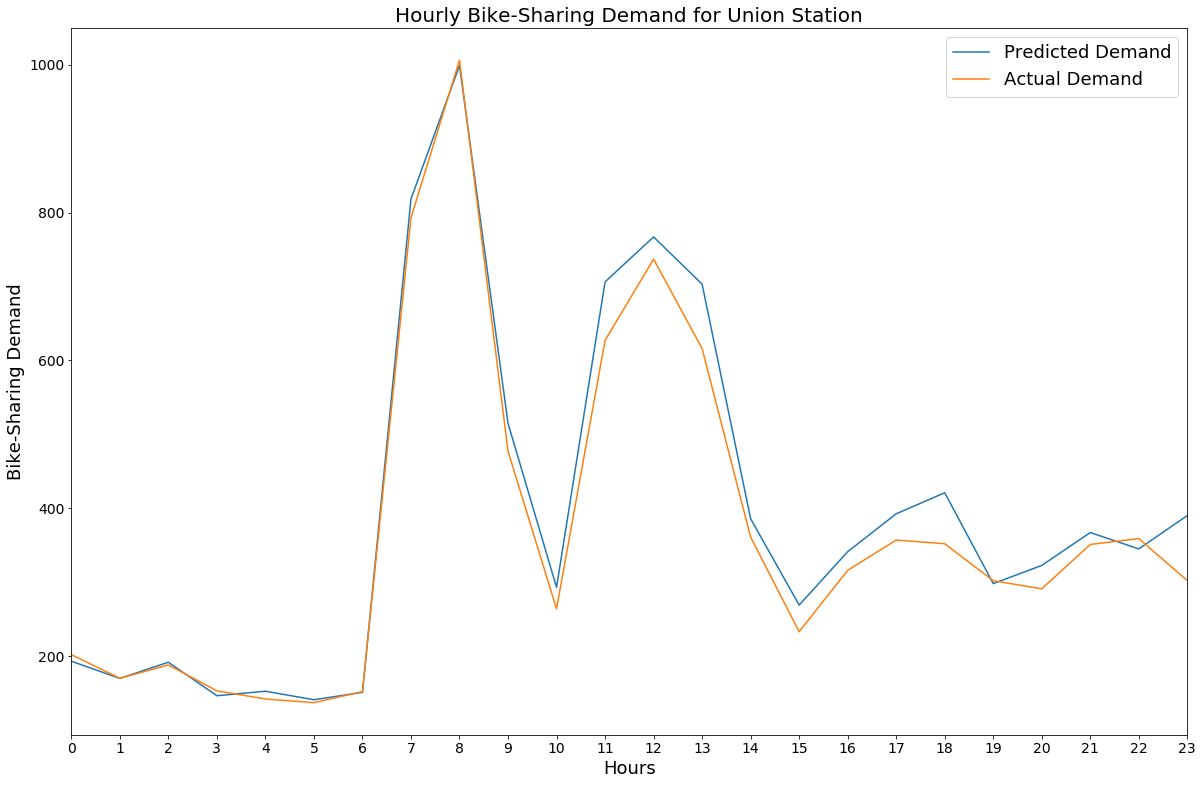

In [110]:
# plot prediction and acutal bike demand for Union station
plt.figure(figsize=(20,13))
pred.plot()
actual.plot()
# plot title
plt.title("Hourly Bike-Sharing Demand for Union Station",fontsize=20)
# plot legend
plt.legend(['Predicted Demand','Actual Demand'],prop={'size': 18})
# plot y label
plt.ylabel('Bike-Sharing Demand',fontsize=18)
# plot x label
plt.xlabel('Hours',fontsize=18)
# change xticks labels and font size
plt.xticks(Hours,fontsize=14)
# change yticks font size
plt.yticks(fontsize=14)
# save graph
plt.savefig('hourly_demand_Union.png')

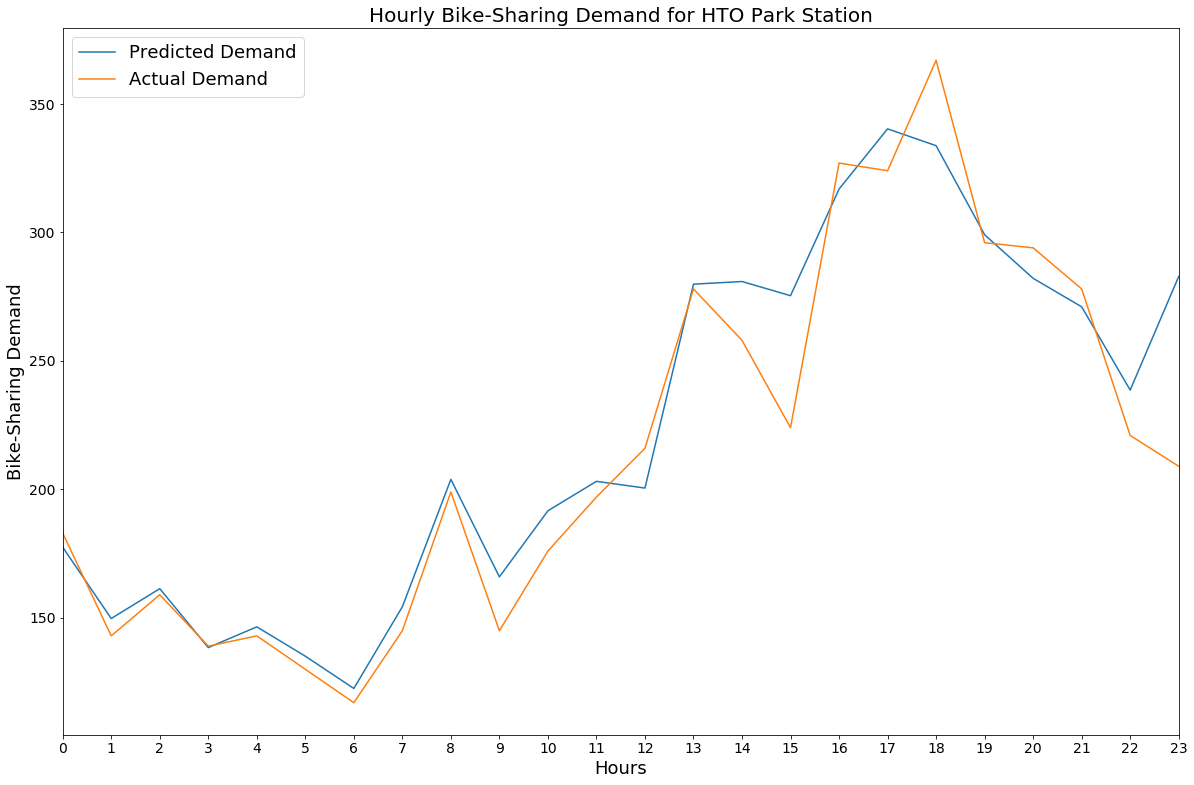

In [117]:
# plot prediction and acutal bike demand for HTO park station
plt.figure(figsize=(20,13))
pred.plot()
actual.plot()
# plot title
plt.title("Hourly Bike-Sharing Demand for HTO Park Station",fontsize=20)
# plot legend
plt.legend(['Predicted Demand','Actual Demand'],prop={'size': 18})
# plot y label
plt.ylabel('Bike-Sharing Demand',fontsize=18)
# plot x label
plt.xlabel('Hours',fontsize=18)
# change xticks labels and font size
plt.xticks(Hours,fontsize=14)
# change yticks font size
plt.yticks(fontsize=14)
# save graph
plt.savefig('hourly_demand_HTOPark.png')

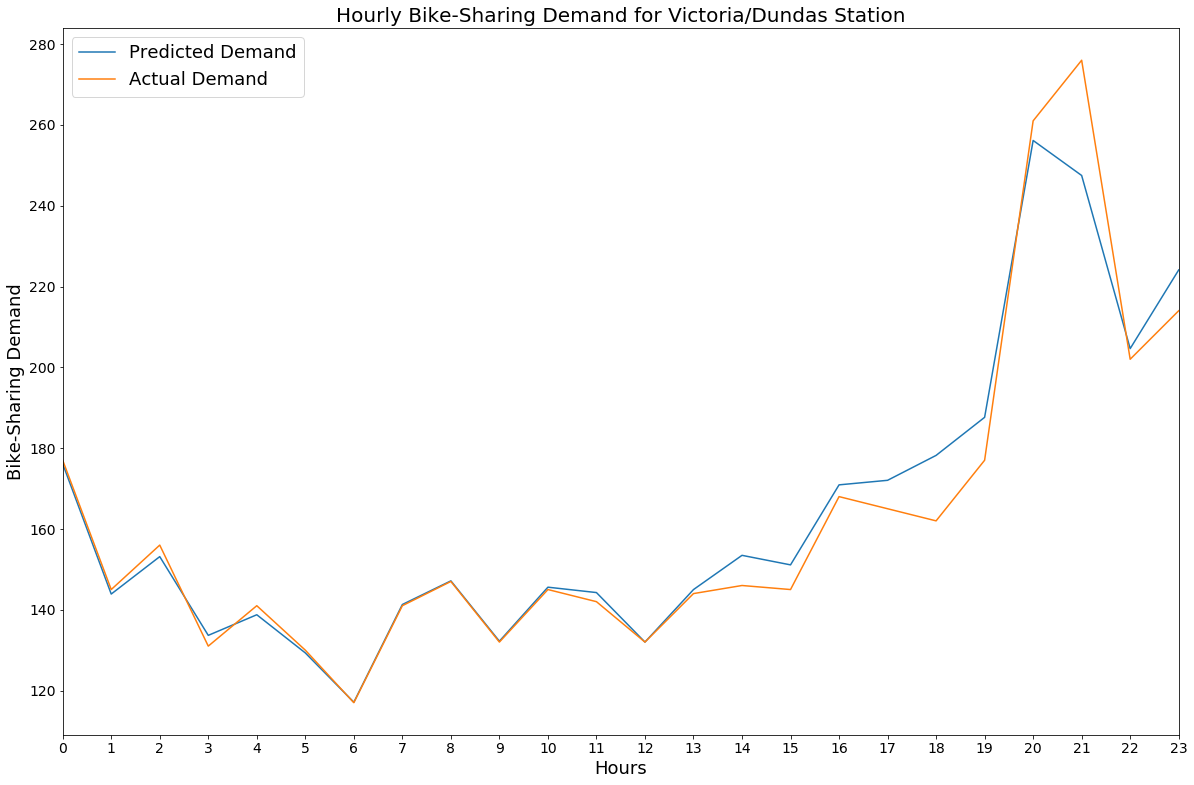

In [123]:
# plot prediction and acutal bike demand for Victoria/Dundas station
plt.figure(figsize=(20,13))
pred.plot()
actual.plot()
# plot title
plt.title("Hourly Bike-Sharing Demand for Victoria/Dundas Station",fontsize=20)
# plot legend
plt.legend(['Predicted Demand','Actual Demand'],prop={'size': 18})
# plot y label
plt.ylabel('Bike-Sharing Demand',fontsize=18)
# plot x label
plt.xlabel('Hours',fontsize=18)
# change xticks labels and font size
plt.xticks(Hours,fontsize=14)
# change yticks font size
plt.yticks(fontsize=14)
# save graph
plt.savefig('hourly_demand_VictoriaDundas.png')

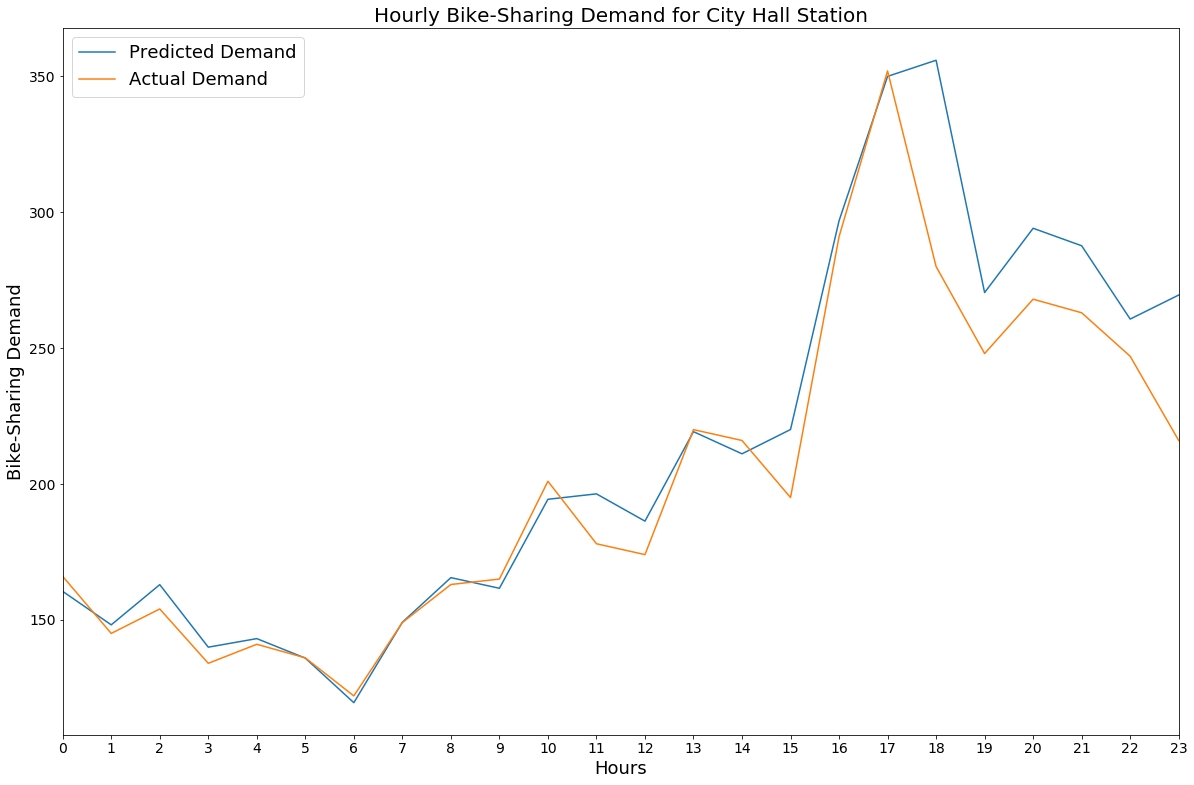

In [104]:
# plot prediction and acutal bike demand for City Hall station
plt.figure(figsize=(20,13))
pred.plot()
actual.plot()
# plot title
plt.title("Hourly Bike-Sharing Demand for City Hall Station",fontsize=20)
# plot legend
plt.legend(['Predicted Demand','Actual Demand'],prop={'size': 18})
# plot y label
plt.ylabel('Bike-Sharing Demand',fontsize=18)
# plot x label
plt.xlabel('Hours',fontsize=18)
# change xticks labels and font size
plt.xticks(Hours,fontsize=14)
# change yticks font size
plt.yticks(fontsize=14)
# save graph
plt.savefig('hourly_demand_CityHall.png')

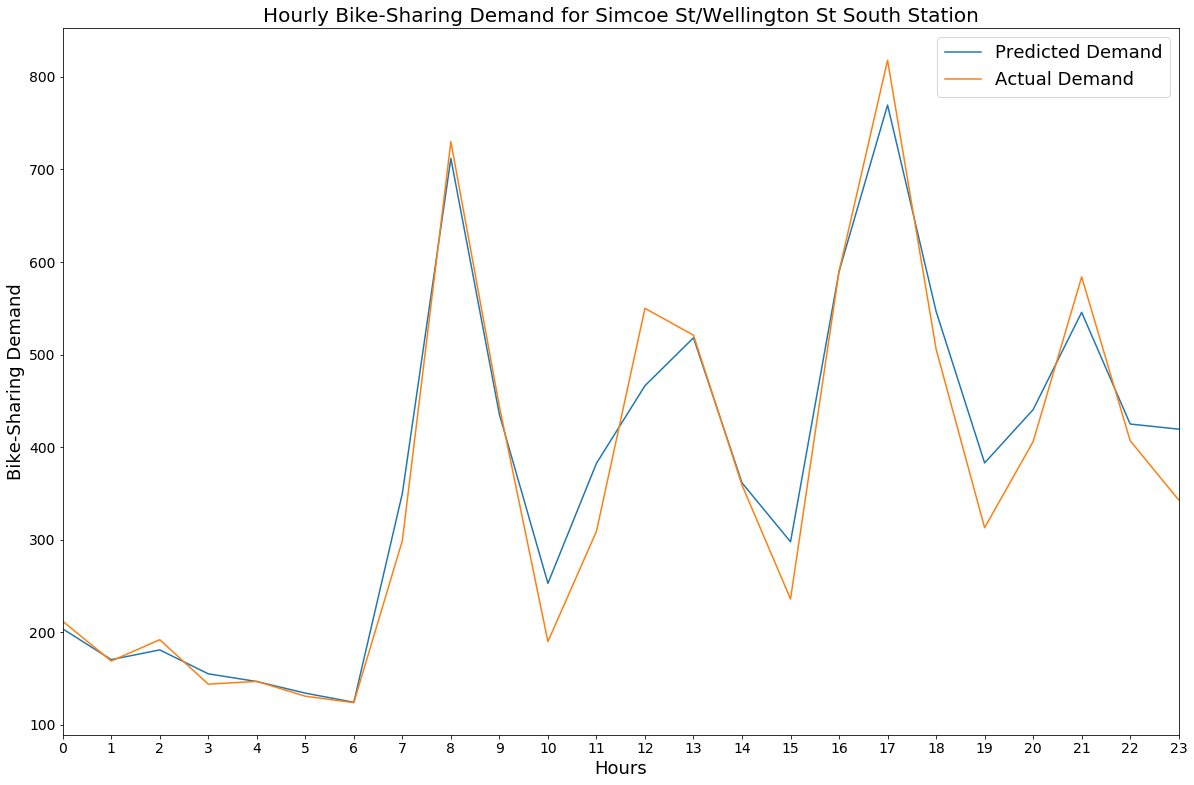

In [265]:
# plot prediction and acutal bike demand for Union station
plt.figure(figsize=(20,13))
pred.plot()
actual.plot()
# plot title
plt.title("Hourly Bike-Sharing Demand for Simcoe St/Wellington St South Station",fontsize=20)
# plot legend
plt.legend(['Predicted Demand','Actual Demand'],prop={'size': 18})
# plot y label
plt.ylabel('Bike-Sharing Demand',fontsize=18)
# plot x label
plt.xlabel('Hours',fontsize=18)
# change xticks labels and font size
plt.xticks(Hours,fontsize=14)
# change yticks font size
plt.yticks(fontsize=14)
# save graph
plt.savefig('hourly_demand_SimcoeWellington.png')